In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [23]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [24]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [25]:
owned_shares = pd.read_csv('../csv_files/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [26]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,8653,-7933,720,391,611,1048,8031,11164,0,...,41841,3636,0,3957,9005,4346,18782,1090,-1294,273
1,2014-03-31,8551,-8010,541,153,289,1261,8108,10998,0,...,41861,3332,0,3999,8854,4413,18737,442,-867,273
2,2014-06-30,9438,-8607,831,296,1284,1523,7212,11406,0,...,42542,3421,0,4281,9377,4802,19669,1818,-904,273
3,2014-09-30,9287,-8179,1108,615,544,1380,7384,10646,0,...,41687,3424,0,3036,8122,4578,18233,1447,-719,273
4,2014-12-31,9615,-8109,1506,835,865,1344,7885,11570,0,...,43865,3764,0,2845,8823,4819,19898,2105,-1001,273


## Calculate date when quaterly reports could be available

In [27]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [28]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,3533,96376,10335,0,414,15832,10639,38065,7295,-3724
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804


## Pull historical average USD national currency rates and add to the dataframe

In [29]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [30]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,273,23577,-19474,4103,2577,12159,3830,22278,...,96376,10335,0,414,15832,10639,38065,7295,-3724,10.721097
37,2023-03-31,2023-04-21,273,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
38,2023-06-30,2023-07-21,273,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
39,2023-09-30,2023-10-21,273,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
40,2023-12-31,2024-02-11,273,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [31]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [32]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [33]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [34]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,69.562210,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
1,2014-02-24,68.884880,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
2,2014-03-03,66.107819,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
3,2014-03-10,62.213131,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826
4,2014-03-17,62.856602,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,0.55111,0.44889,33.026718,8.727173,56.648118,3.951189,0.083208,0.045187,0.03738,0.067826


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [35]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,69.562210,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,3.951189,0.083208,0.045187,0.03738,0.067826,12.142253,0.823561,0.548668,1.073659,1.991452
1,2014-02-24,68.884880,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,3.951189,0.083208,0.045187,0.03738,0.067826,12.024023,0.815542,0.543325,1.068317,1.972061
2,2014-03-03,66.107819,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,3.951189,0.083208,0.045187,0.03738,0.067826,11.539280,0.782663,0.521421,1.046413,1.892558
3,2014-03-10,62.213131,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,3.951189,0.083208,0.045187,0.03738,0.067826,10.859453,0.736553,0.490702,1.015694,1.781060
4,2014-03-17,62.856602,2013-12-31,8653.0,5.728938,84.465201,273.0,9536.0,34.930403,611.0,...,3.951189,0.083208,0.045187,0.03738,0.067826,10.971773,0.744172,0.495778,1.020769,1.799481


# Calculate Dividend yield and currency-share price correlation

In [36]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

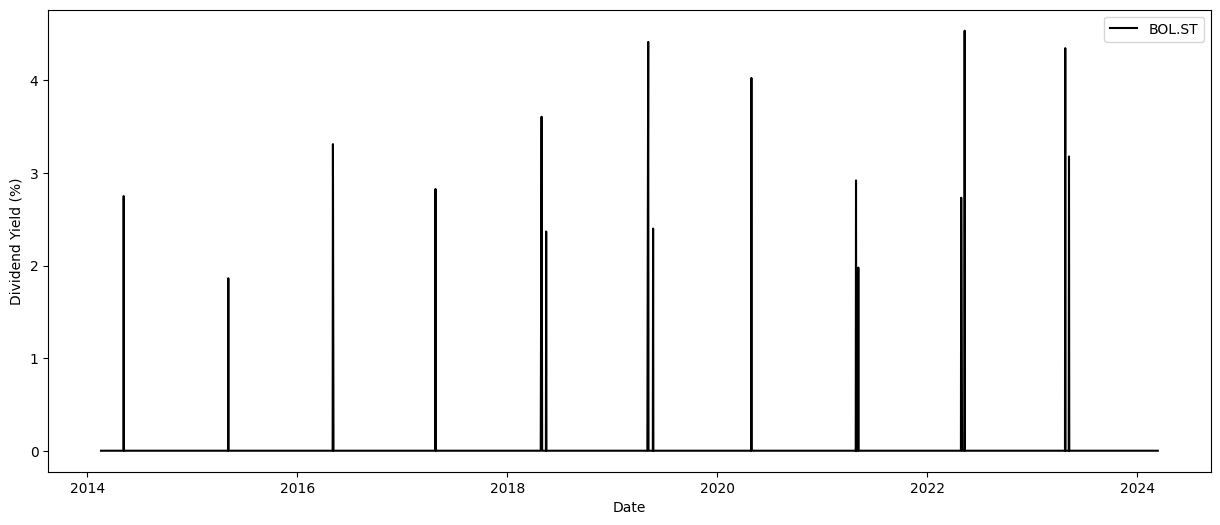

In [37]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.707832
share_price      1.000000
Name: share_price, dtype: float64


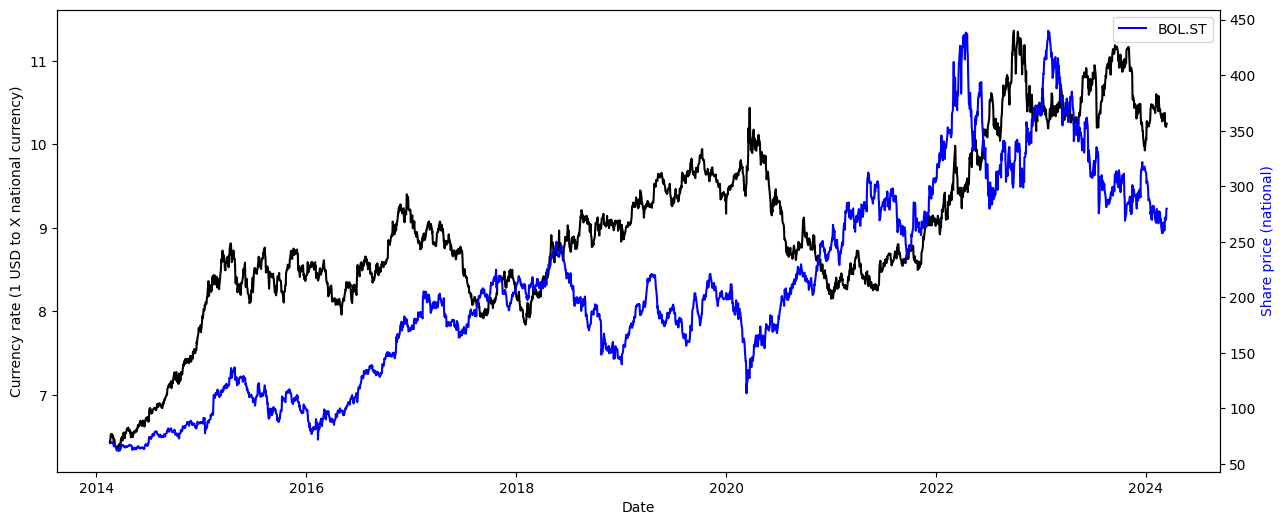

In [38]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

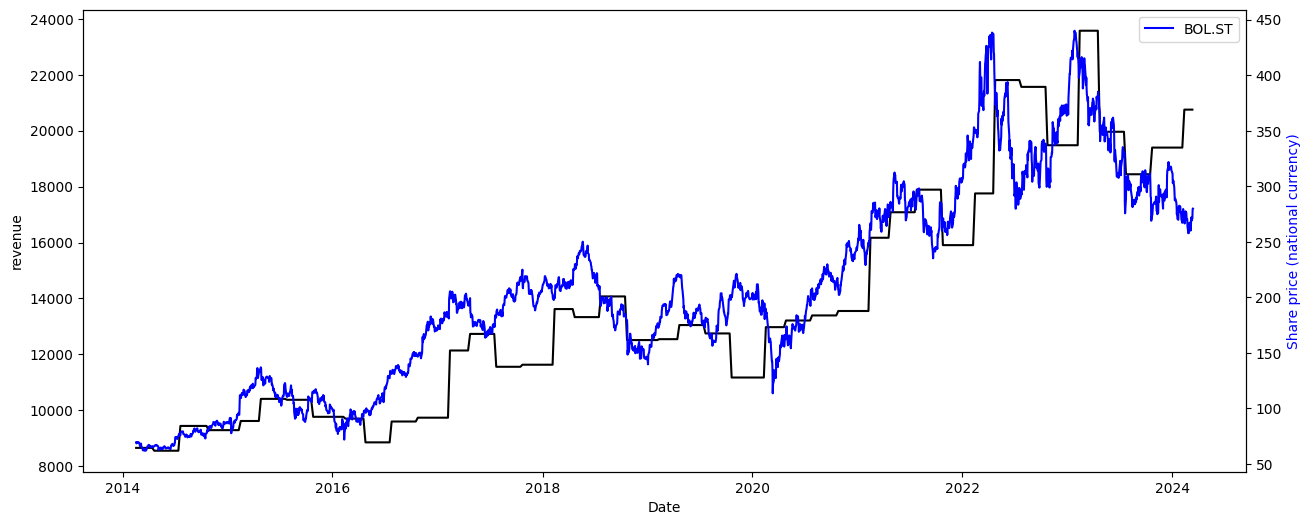

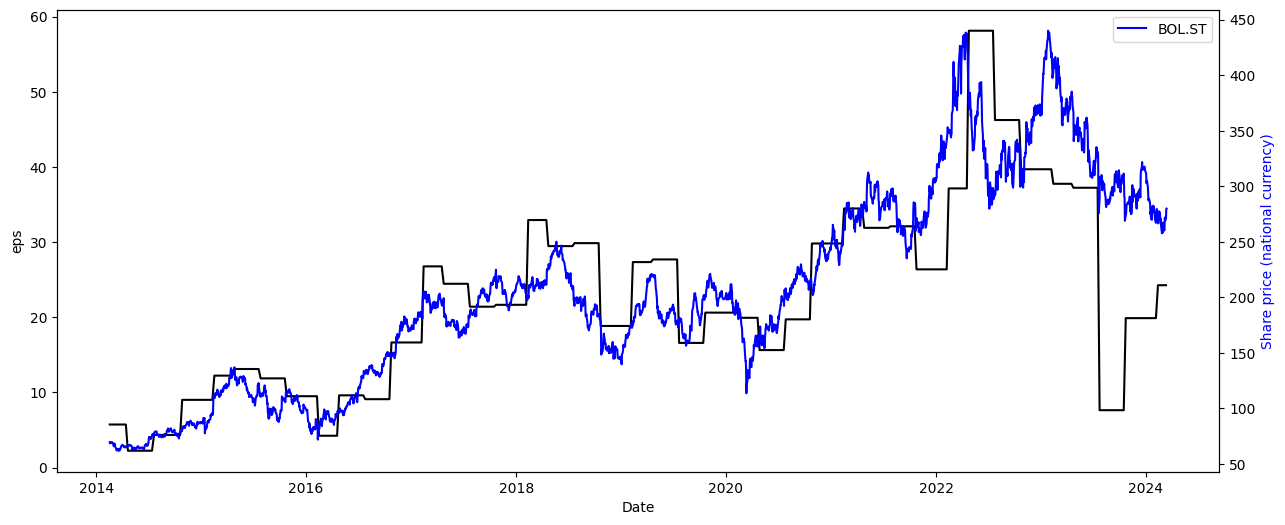

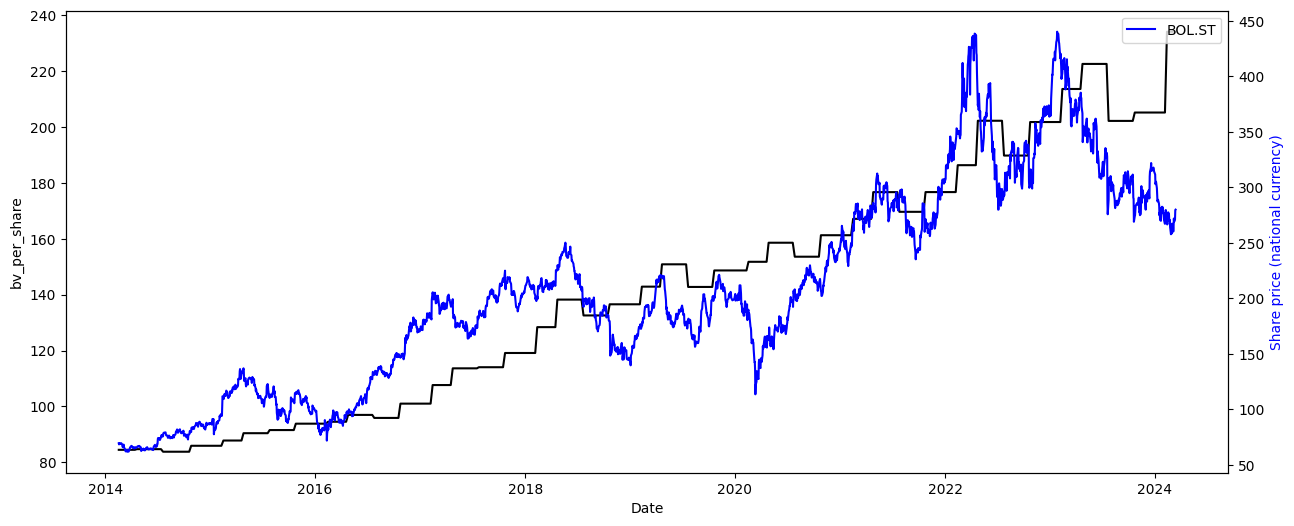

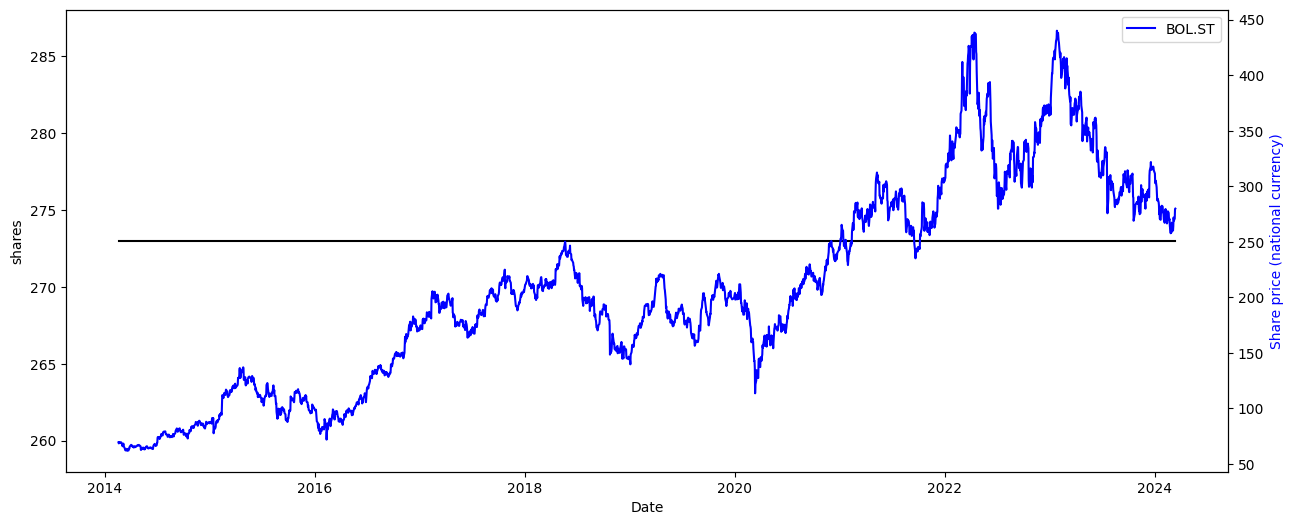

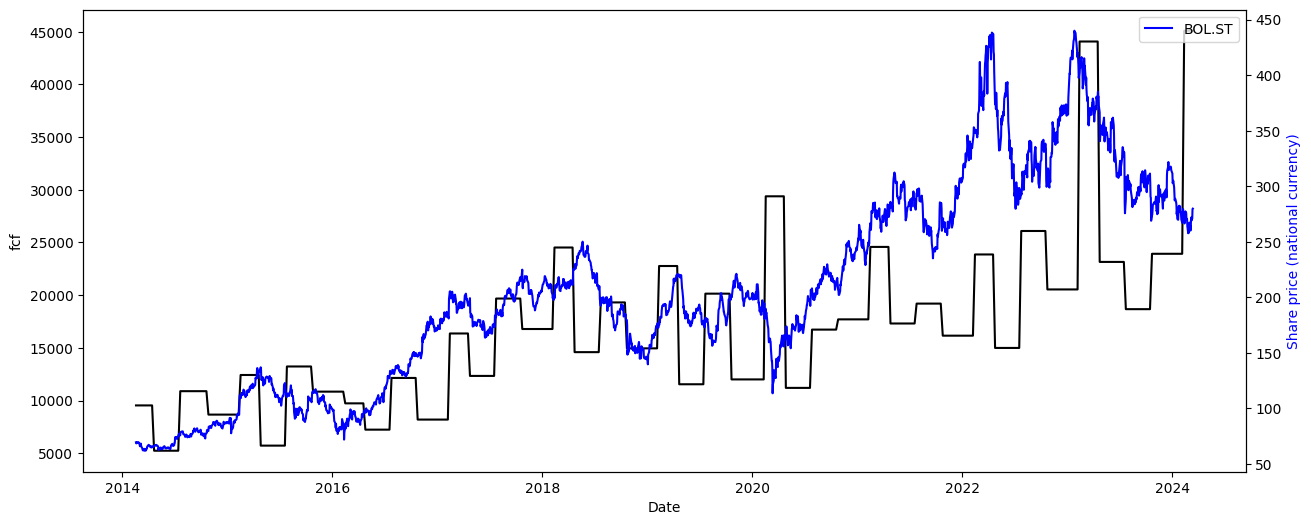

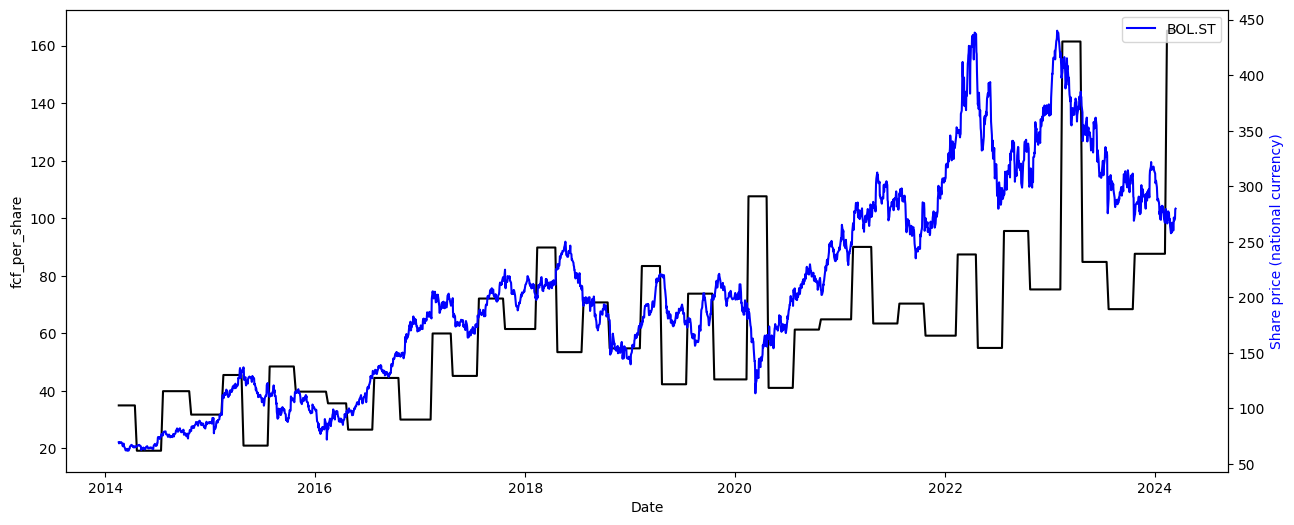

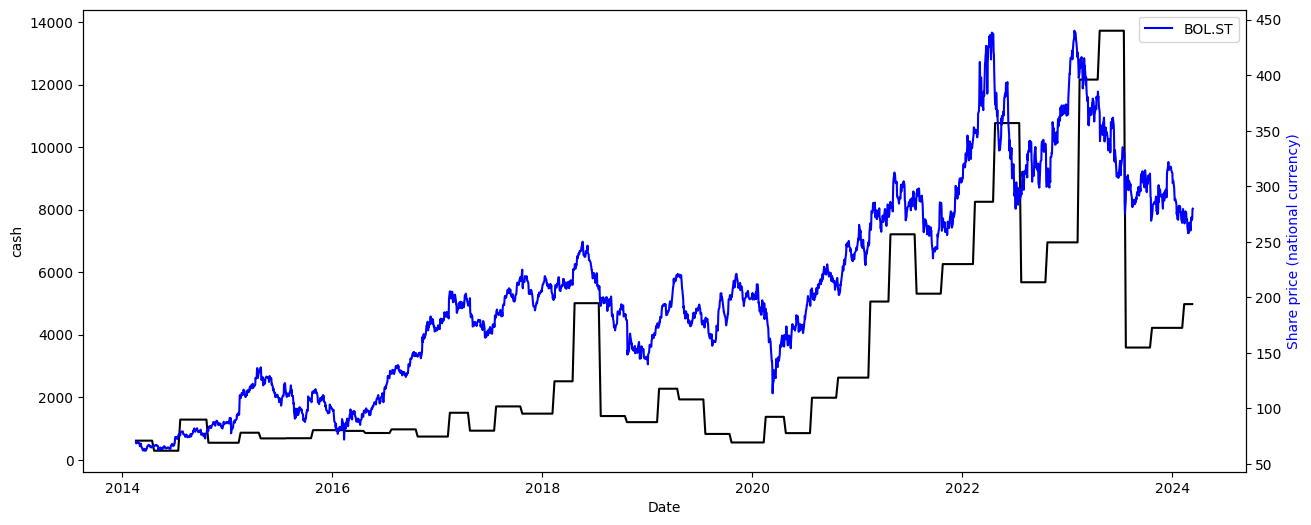

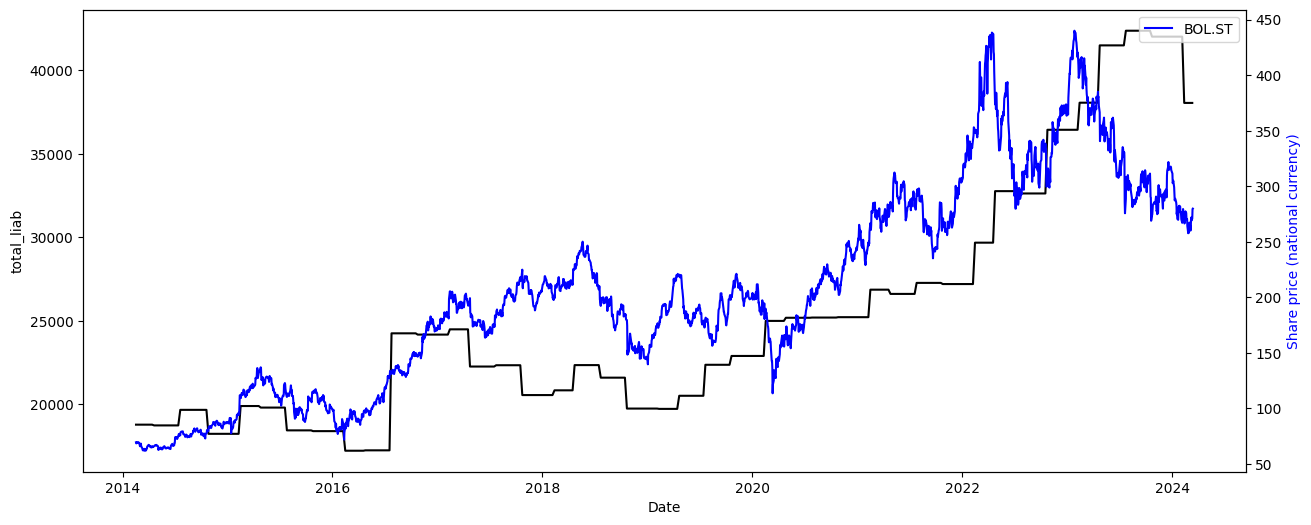

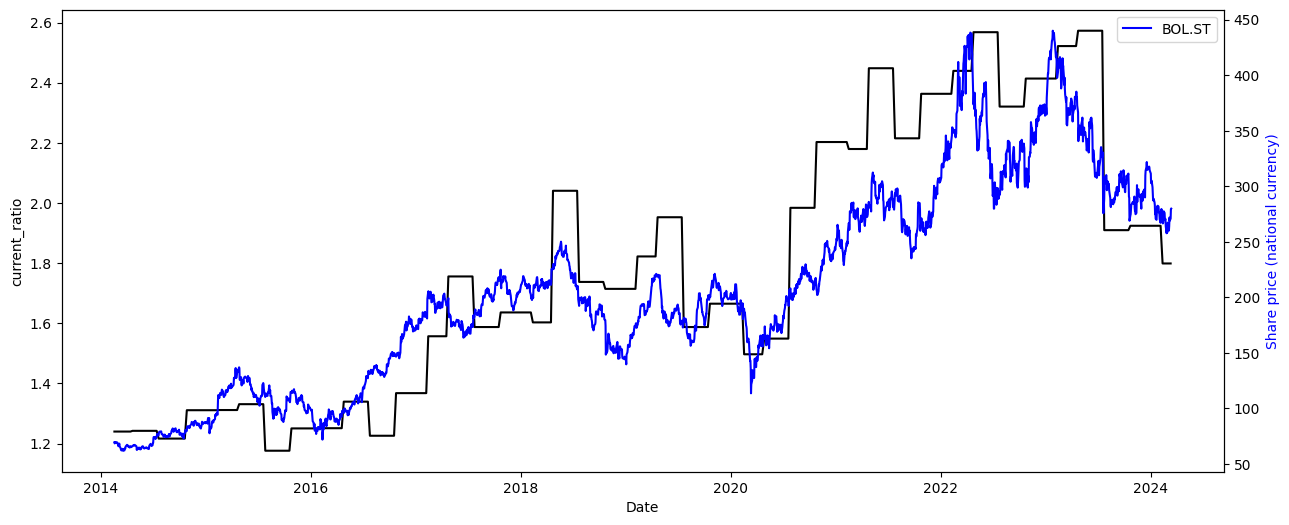

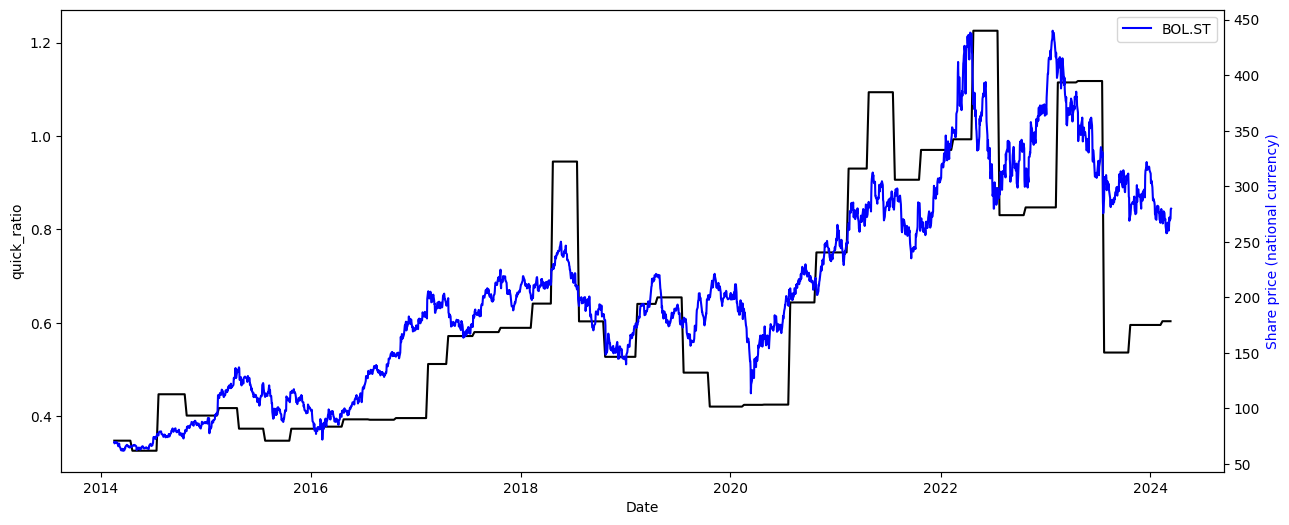

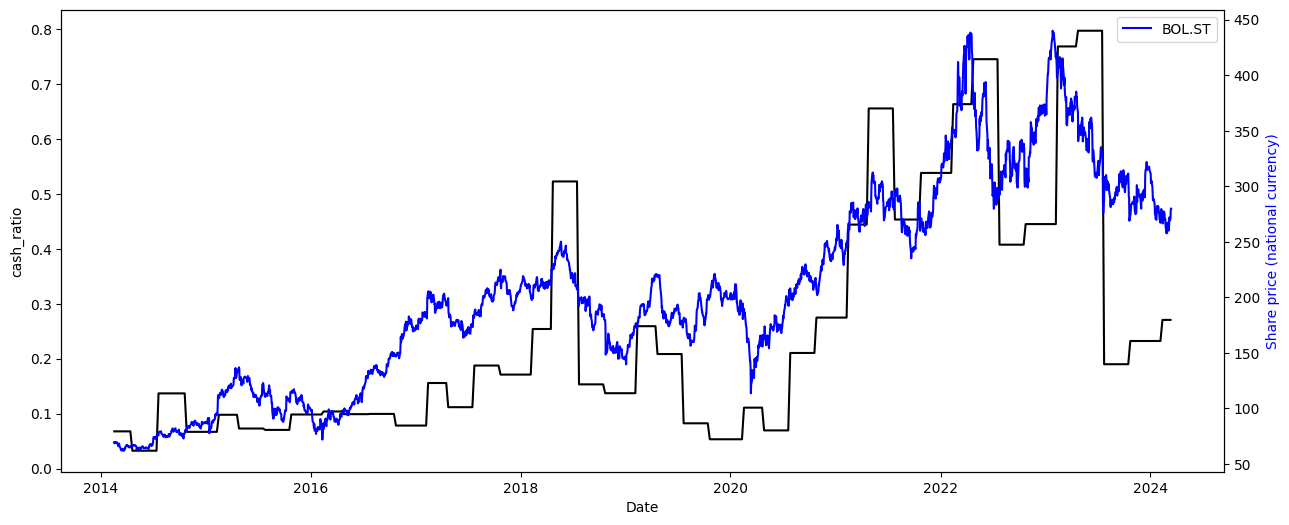

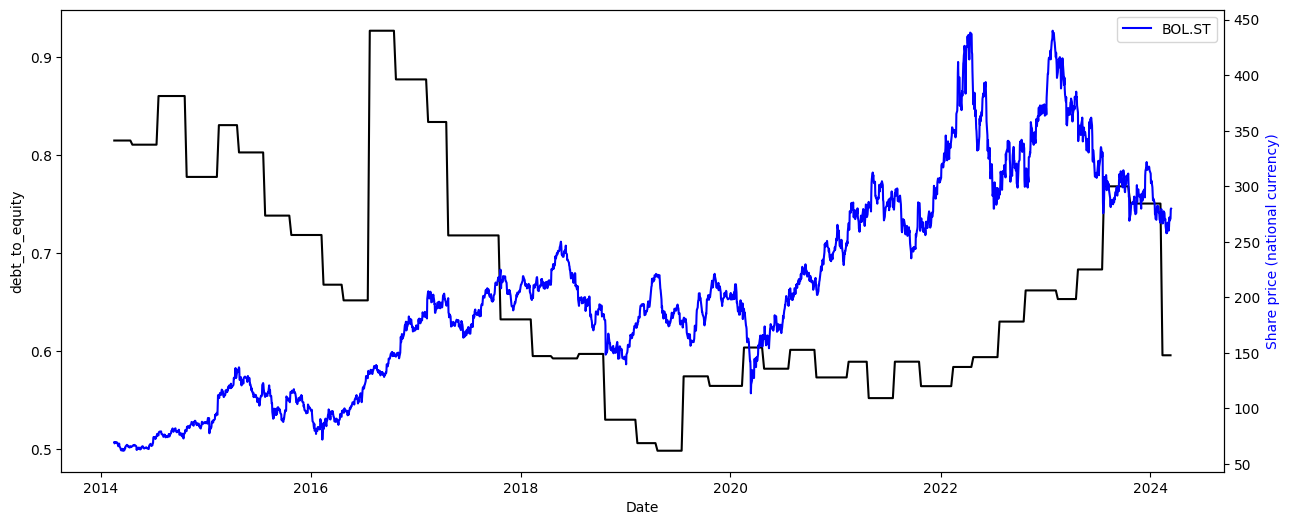

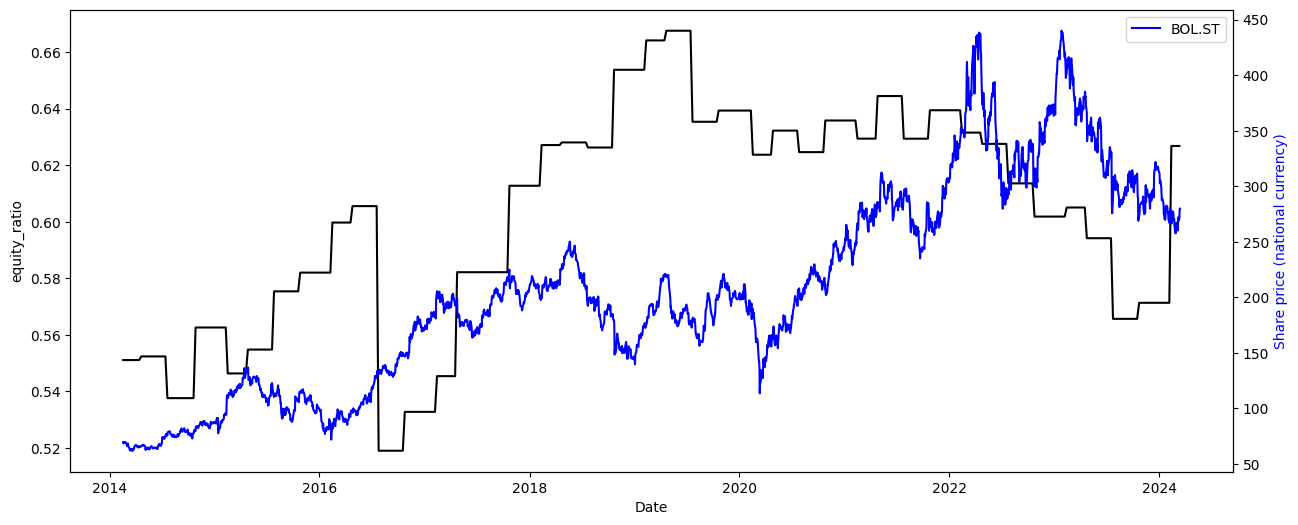

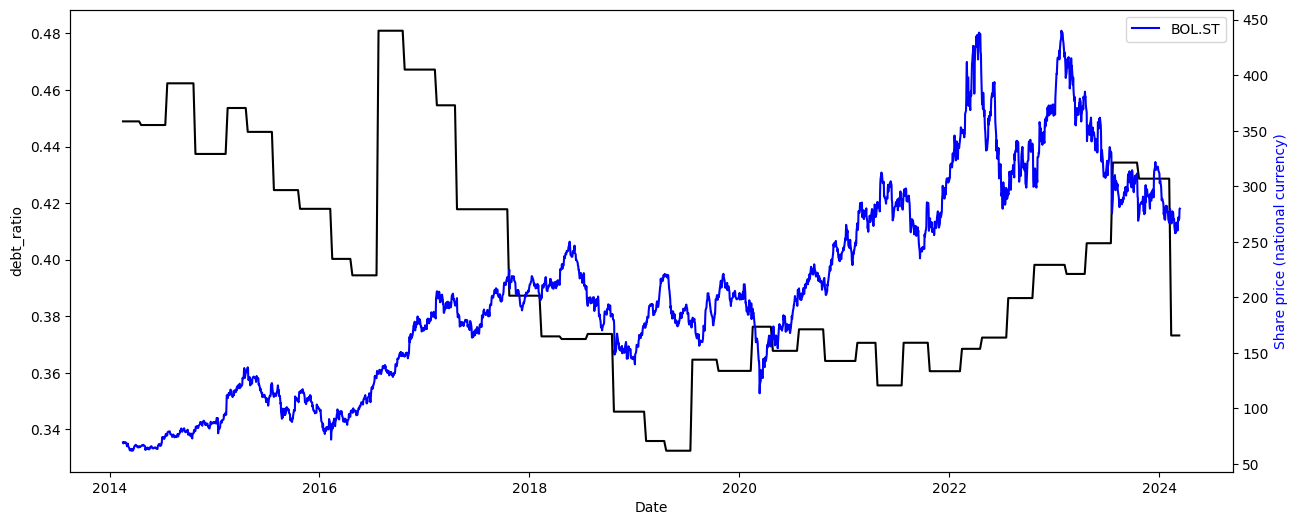

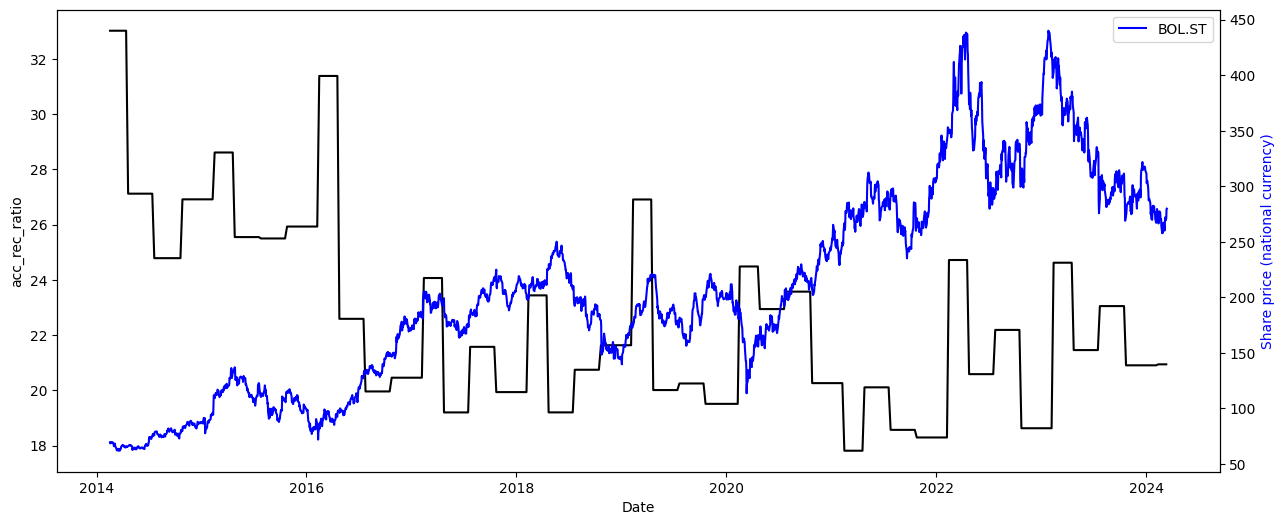

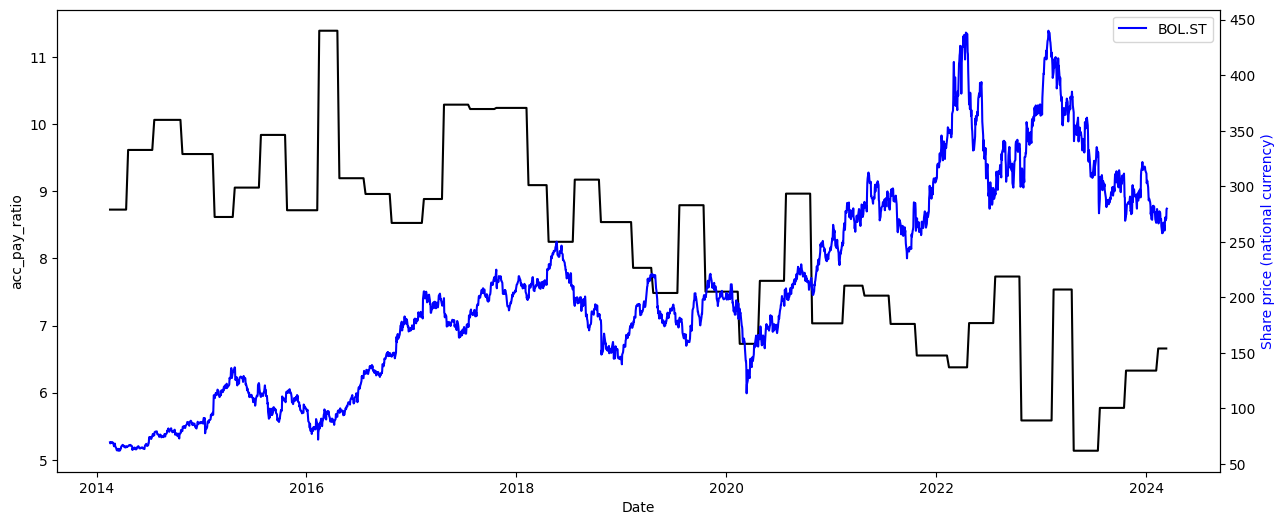

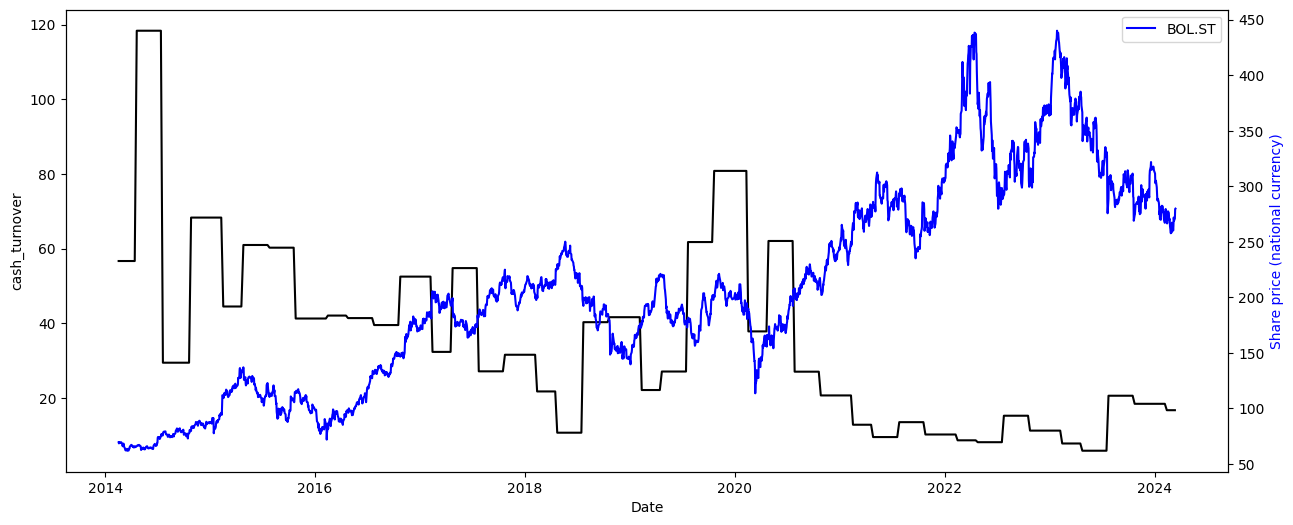

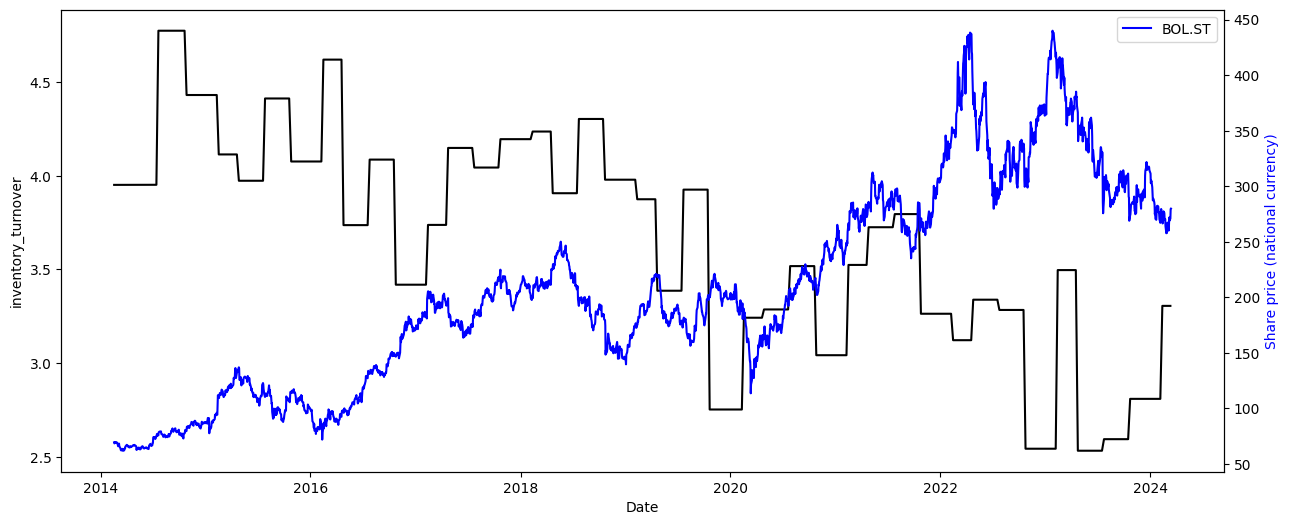

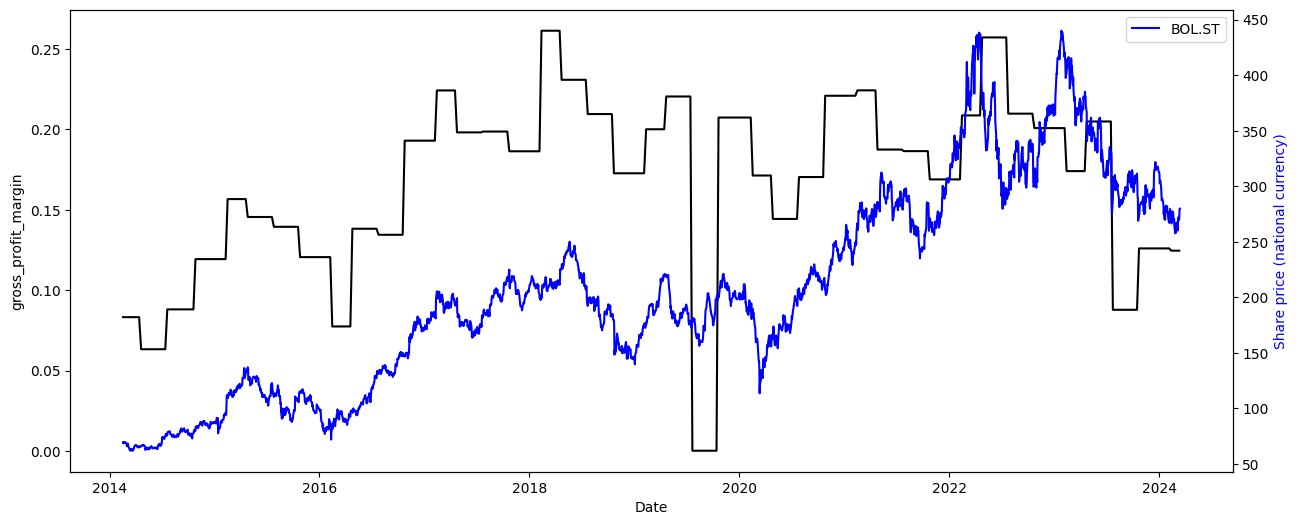

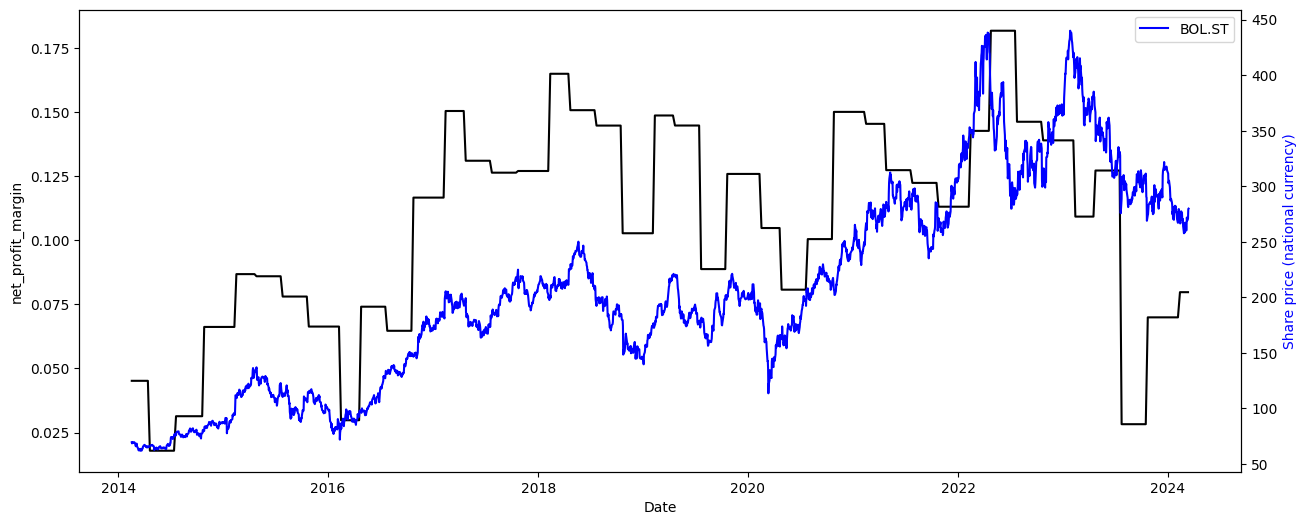

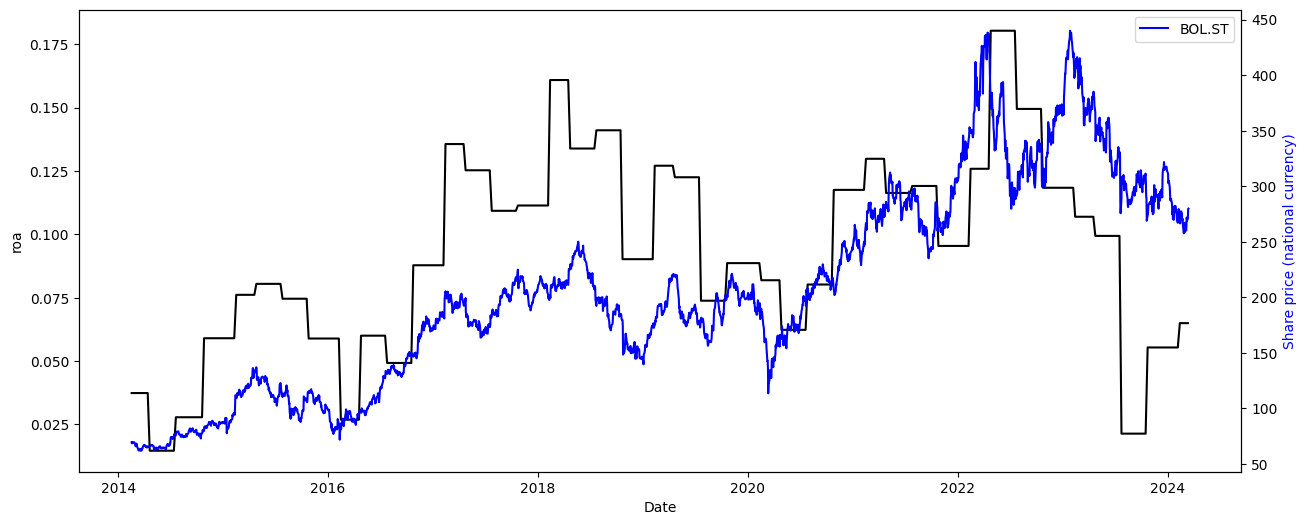

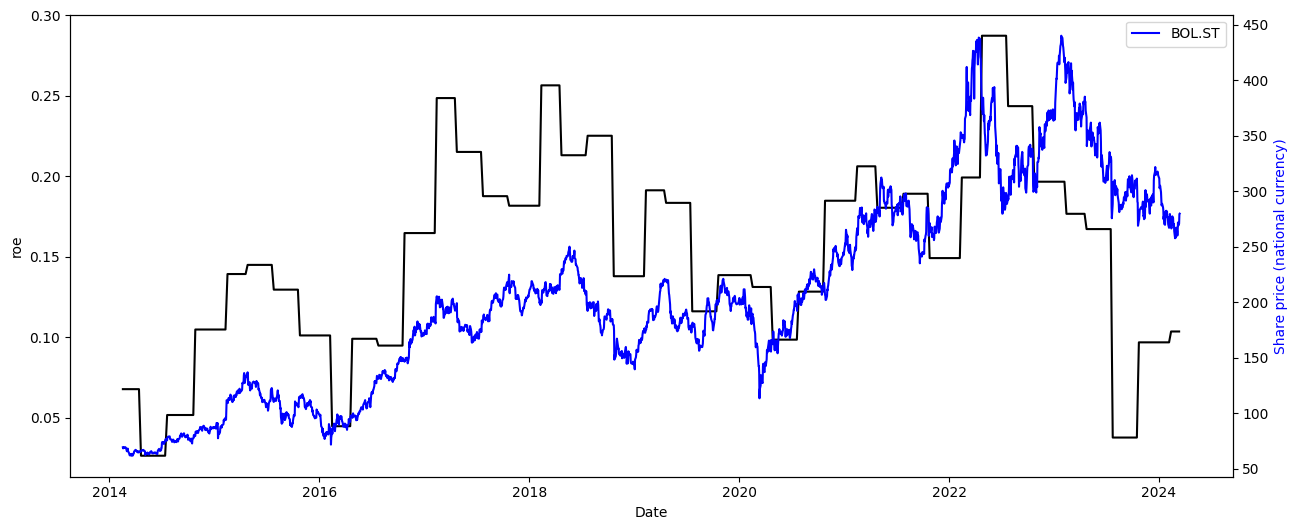

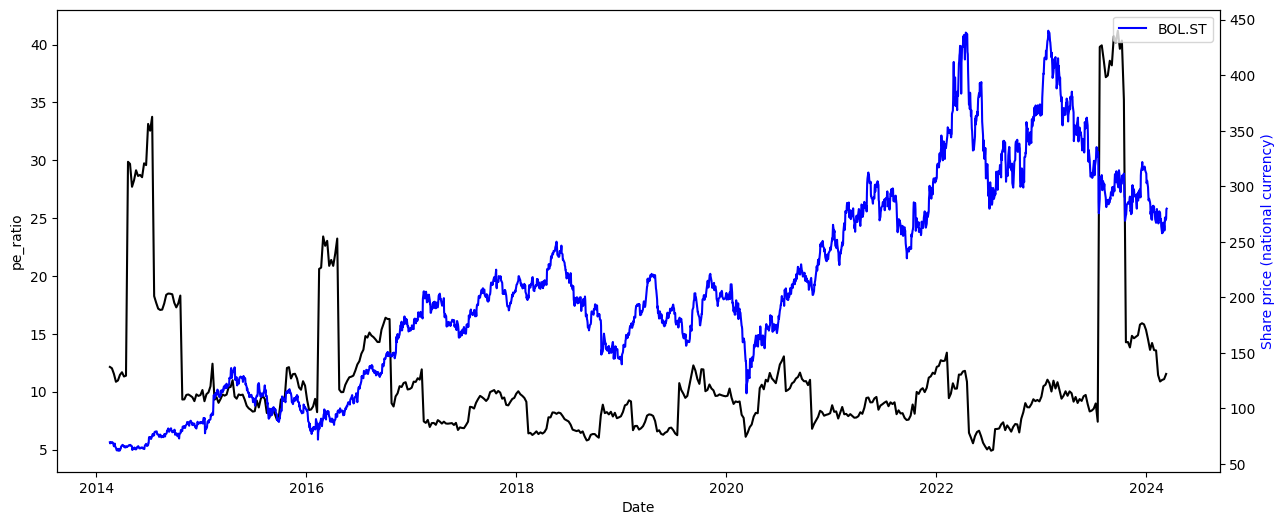

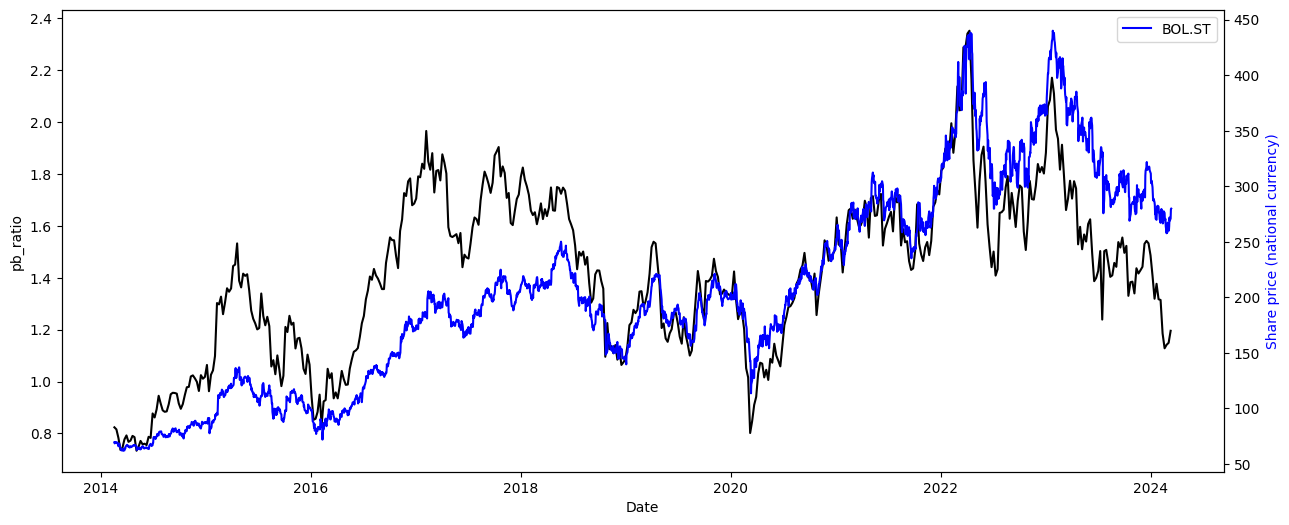

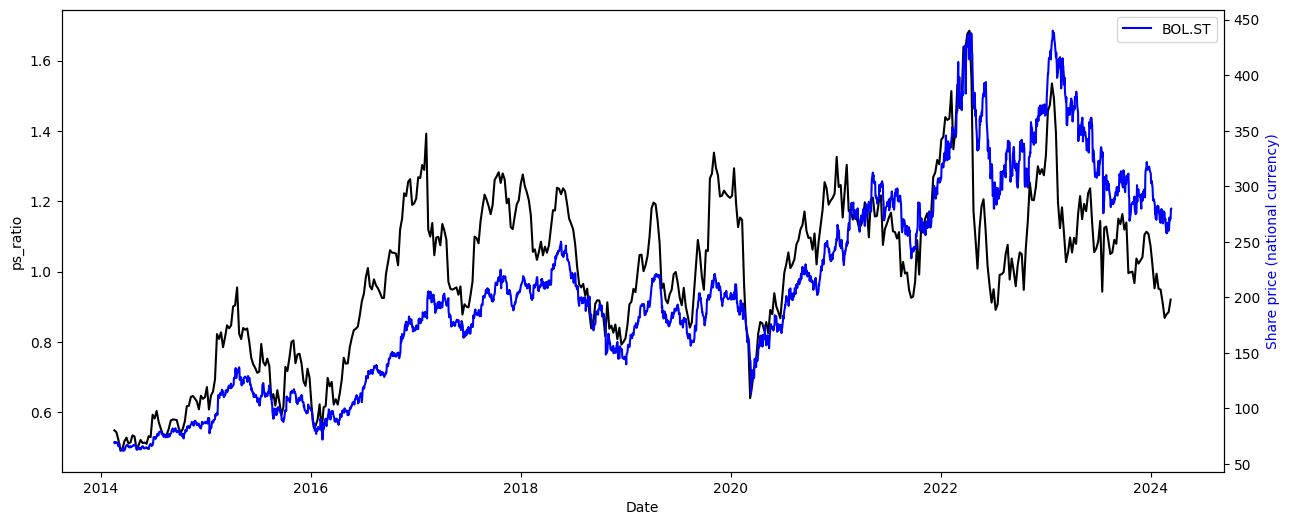

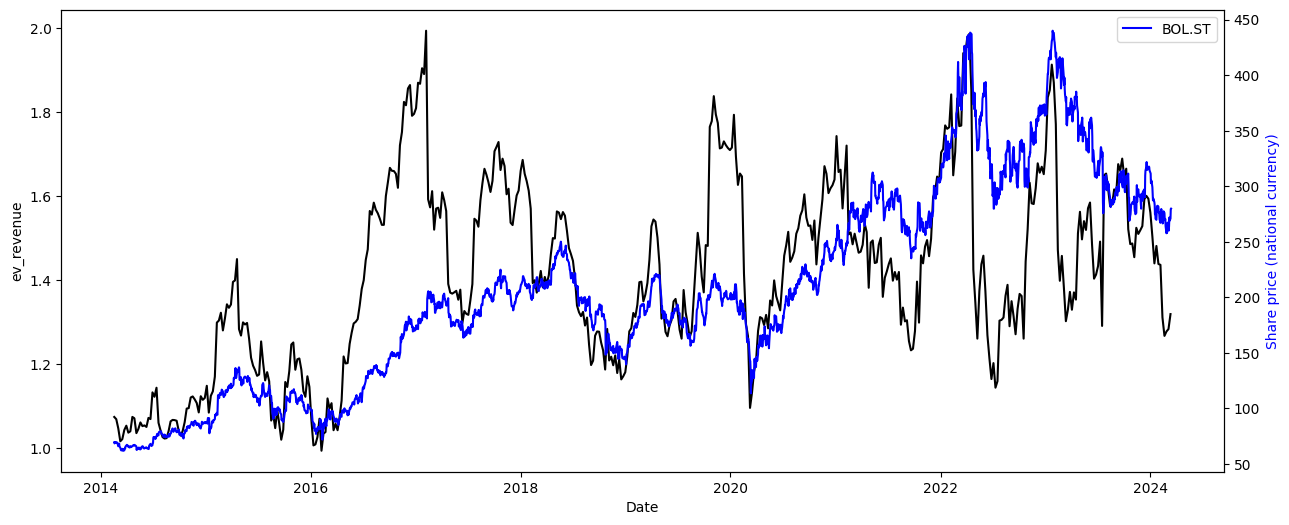

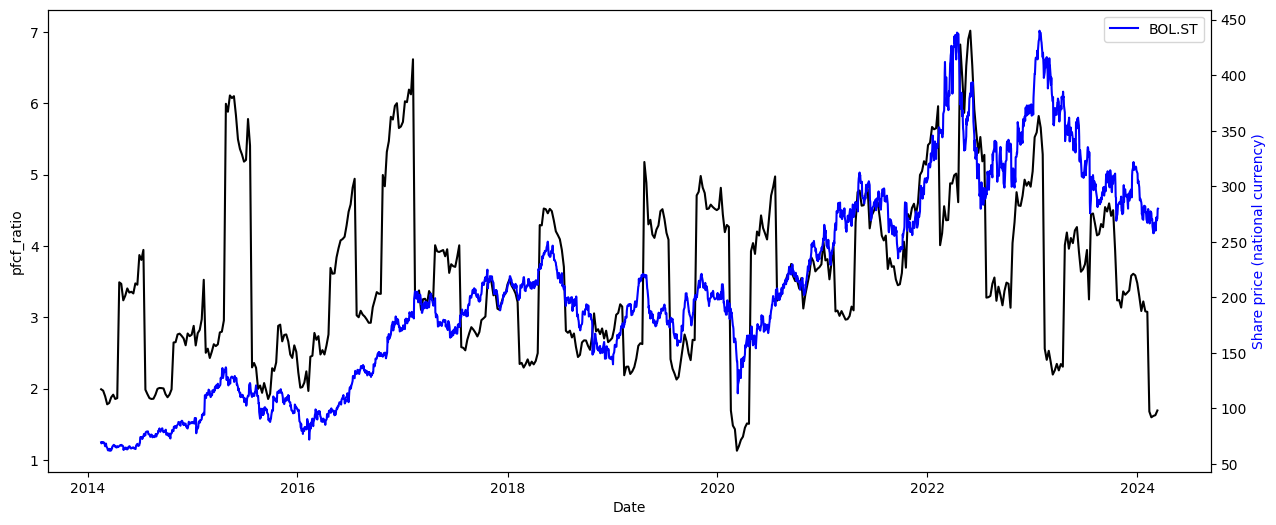

In [39]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

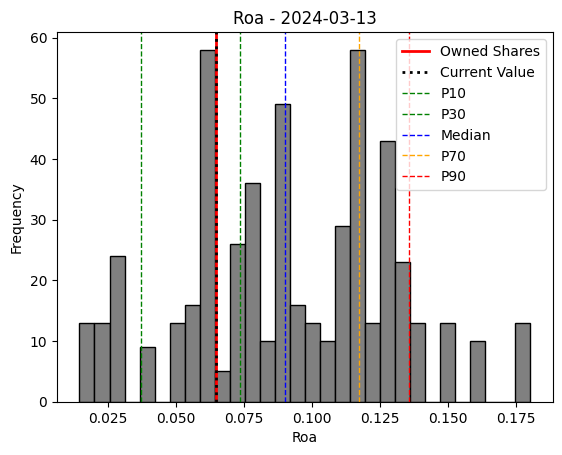

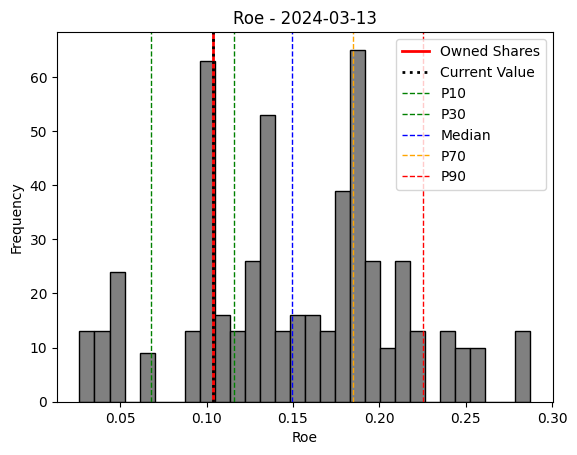

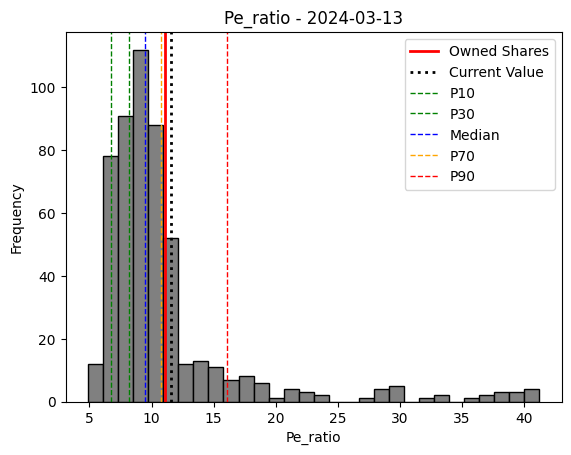

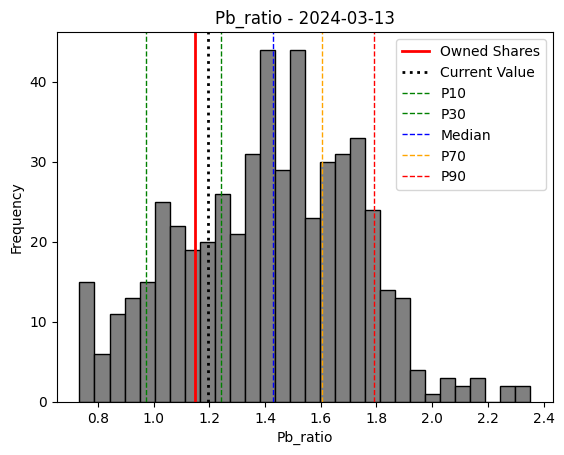

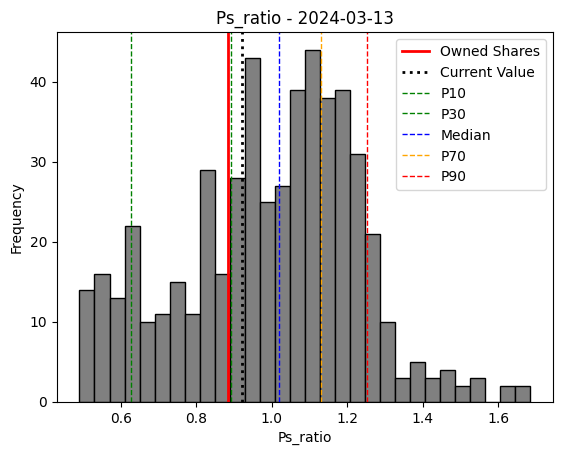

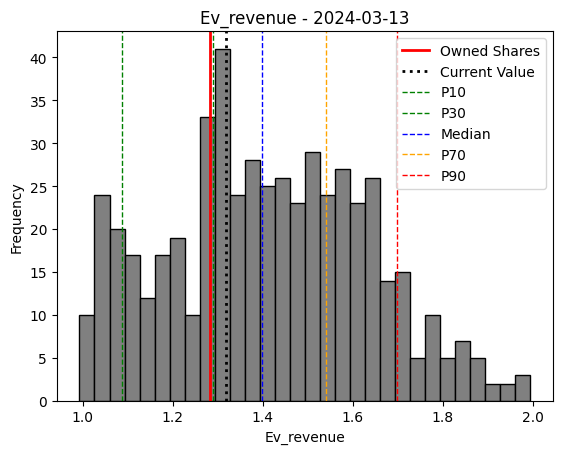

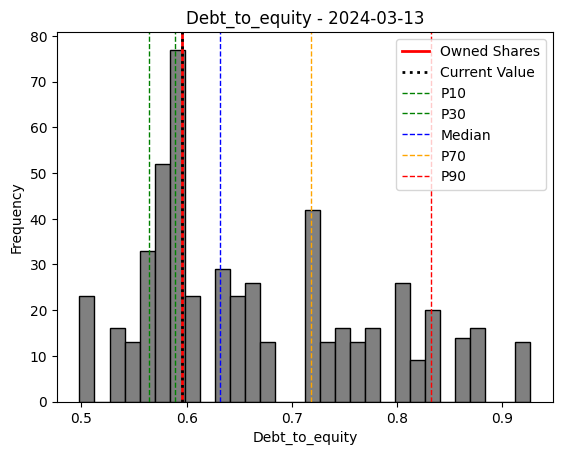

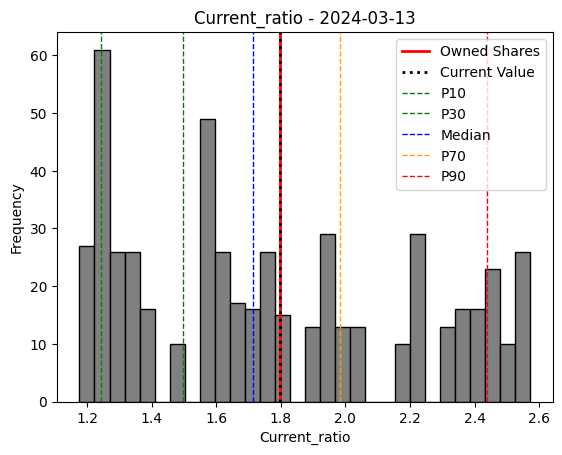

In [40]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [41]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989939,-0.713113,0.666220,0.556007,0.313429,-0.532119,0.621320
roe,0.989939,1.000000,-0.717561,0.693126,0.546378,0.329443,-0.417568,0.573800
pe_ratio,-0.713113,-0.717561,1.000000,-0.255074,-0.199020,-0.032133,0.399143,-0.236783
pb_ratio,0.666220,0.693126,-0.255074,1.000000,0.901943,0.797782,-0.188705,0.634380
ps_ratio,0.556007,0.546378,-0.199020,0.901943,1.000000,0.932021,-0.382053,0.664930
ev_revenue,0.313429,0.329443,-0.032133,0.797782,0.932021,1.000000,-0.121899,0.414370
debt_to_equity,-0.532119,-0.417568,0.399143,-0.188705,-0.382053,-0.121899,1.000000,-0.568474
current_ratio,0.621320,0.573800,-0.236783,0.634380,0.664930,0.414370,-0.568474,1.000000


31 timestemos have been found!


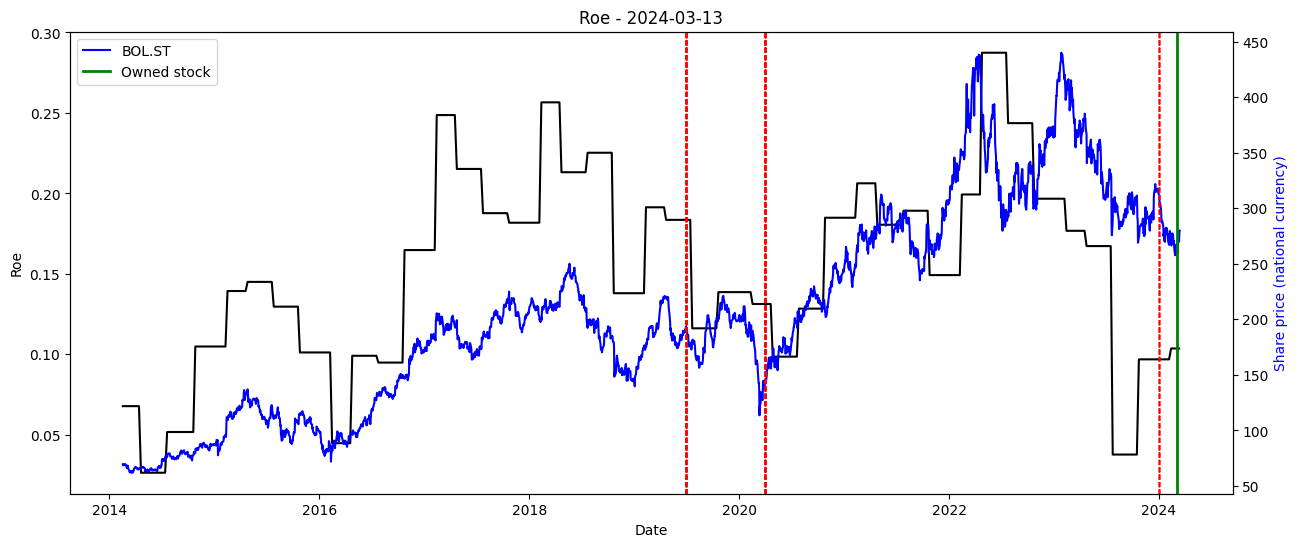

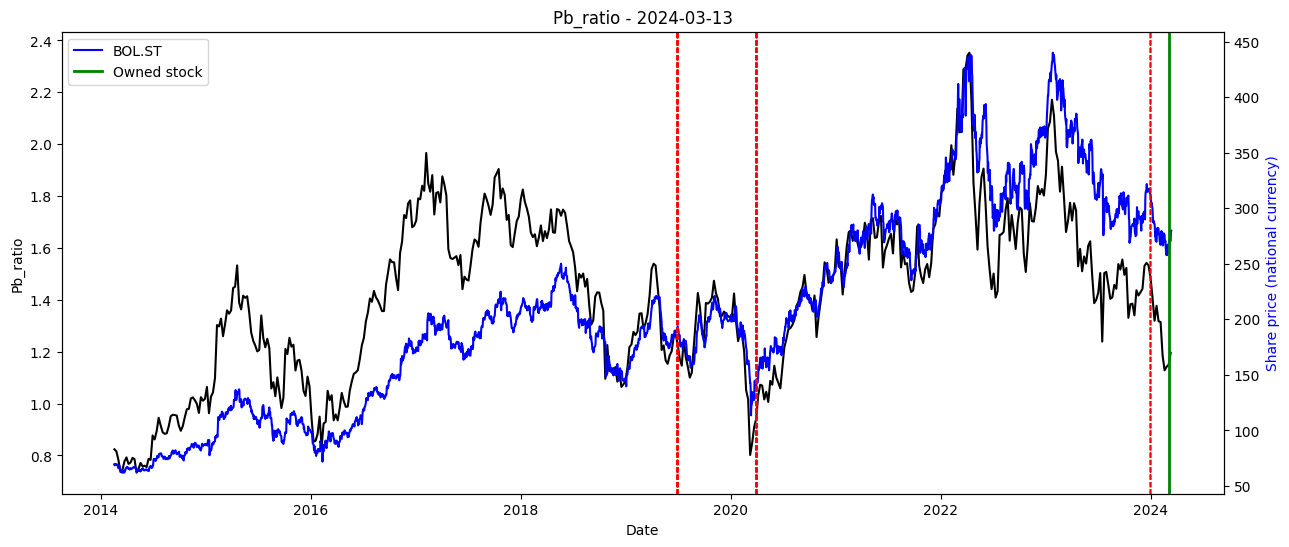

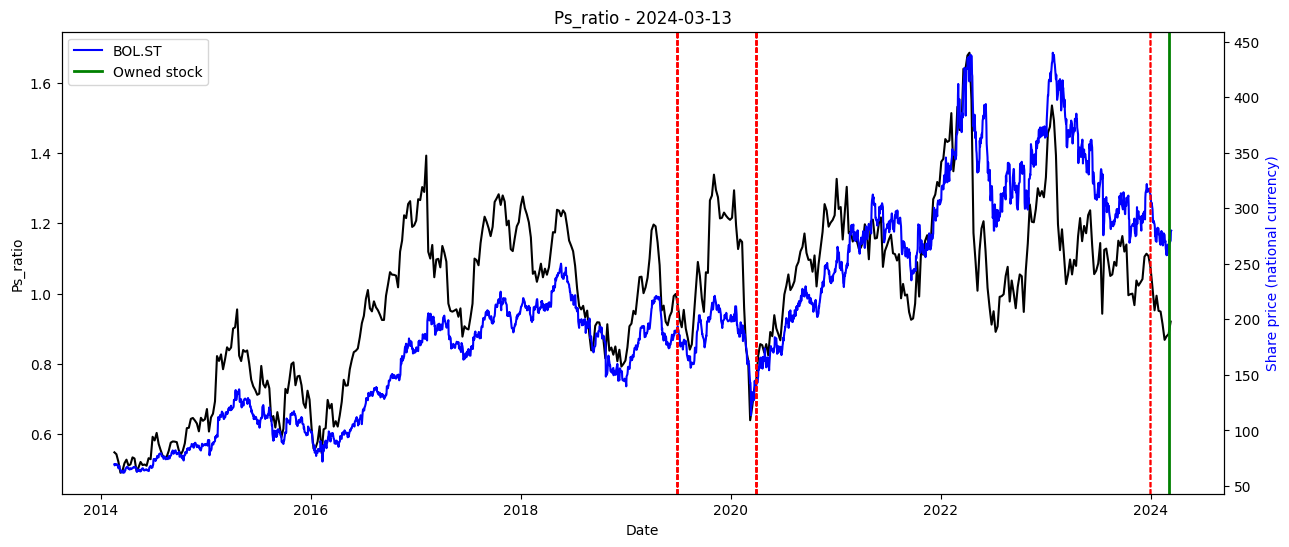

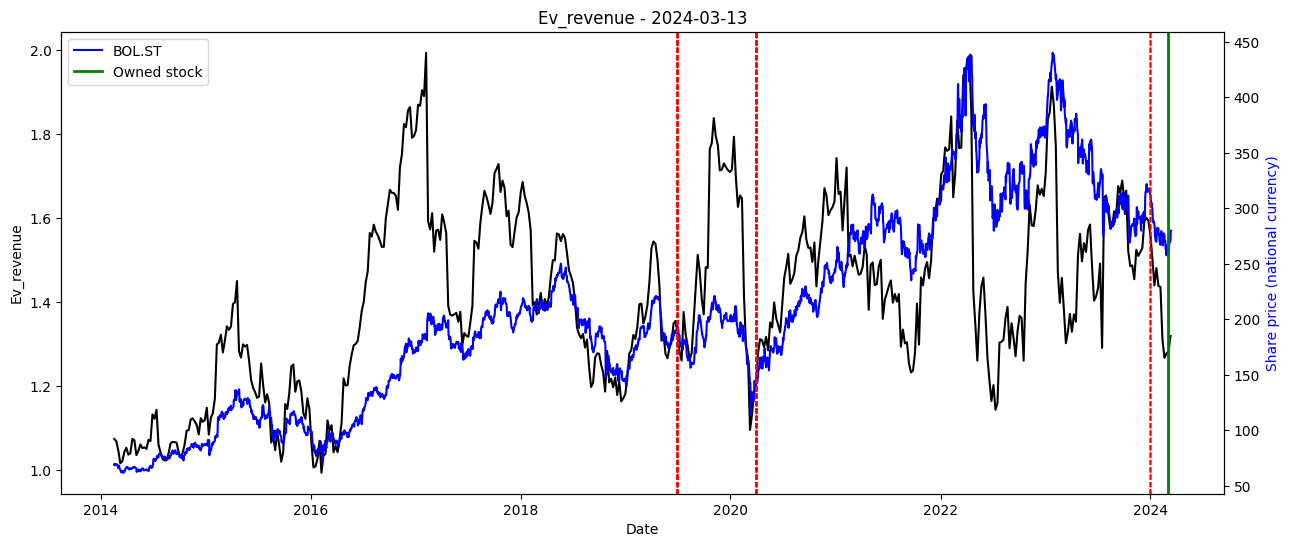

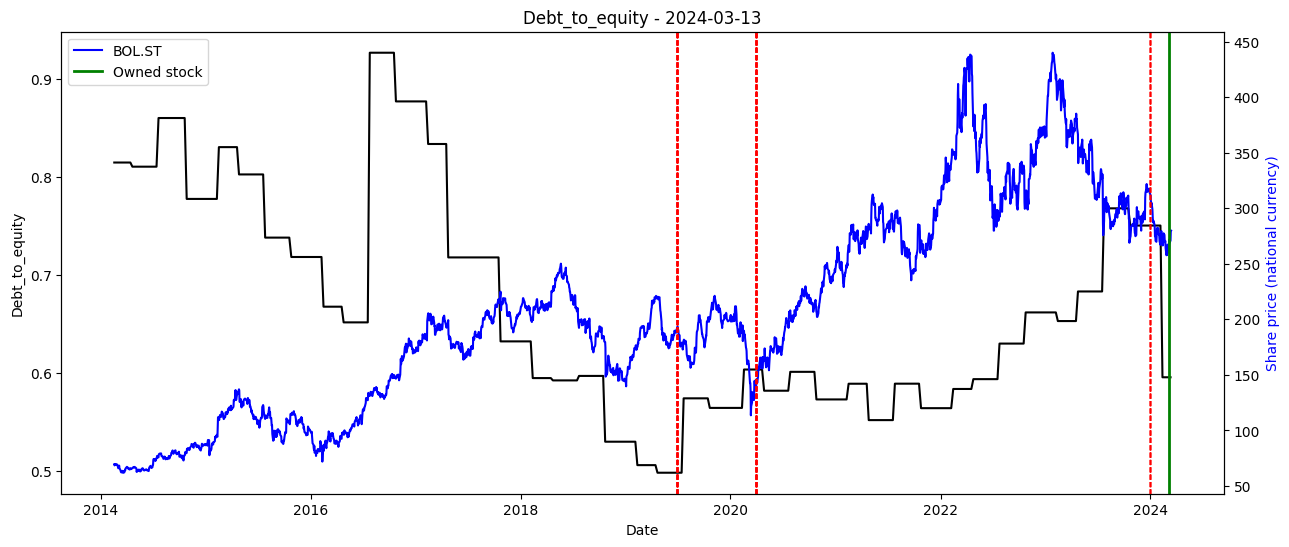

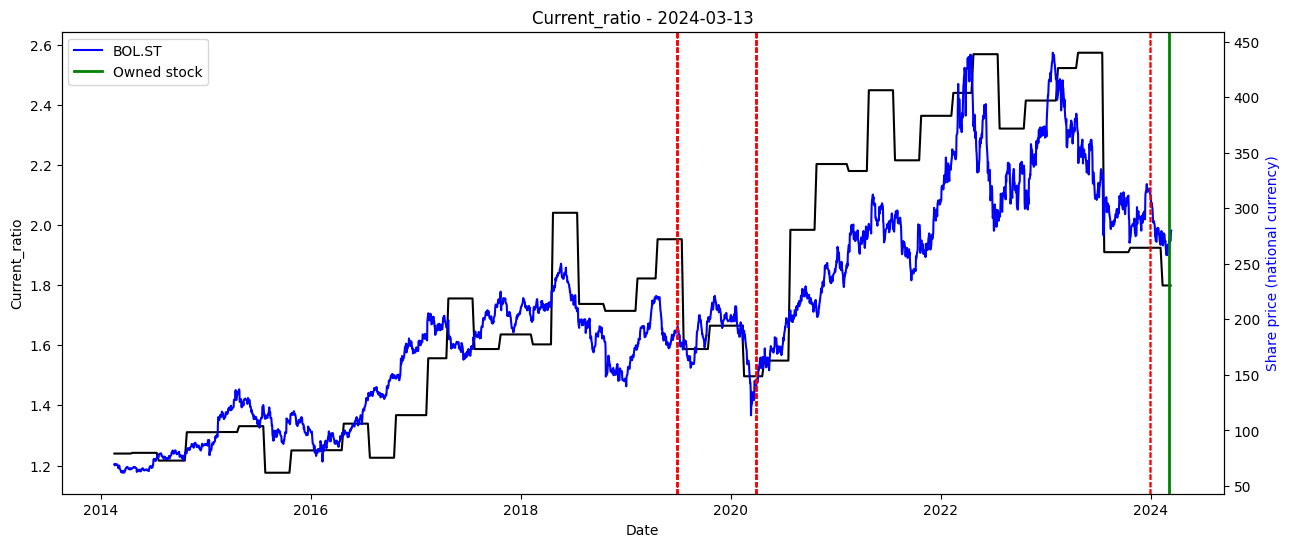

In [42]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )